## Loan Prediction Model with Machine Learning

#### `Objectives`
1. Predict which of the customers will have their loan approved based on different features
2. Implement a logistic regression model and a decision tree model separately to make predictions on the validation data
3. Combine the predictions from the logistic regression and decision tree models and train 

#### `Motivation`
In finance, a loan is the lending of money by one or more individuals, organizations, or other entities to other individuals, organizations, etc. There are many different types of loans and the general structure of the loan includes two parties: the recipient (i.e. the borrower) who incurs a debt and is usually liable to pay interest on that debt and the principal amount until it is repaid in full, and the lender who has the resources and decides whether to lend the money to the recipient on certain conditions. The typical process of obtaining a loan includes the recipient applying for loans with different pieces of information to make themselves eligible for loan, and the lender reviews the information and grants the requested loan amount. 

#### `Data`

We will use a dataset available in [Kaggle](https://www.kaggle.com/datasets/altruistdelhite04/loan-prediction-problem-dataset?resource=download). The data consists of 615 rows and 13 columns, including the `Loan_Status`, which is our labeled data. 

### Step 1: Import packages

In [2]:
# standard
import pandas as pd
import numpy as np
import random
import os
import warnings
from scipy.stats import norm

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import Image, display
##import pydot
##from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

random.seed(2)
%matplotlib inline

#warning hadle
warnings.filterwarnings("ignore")

C:\Users\sunny\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Step 2: Import data

#### `Step 2.1: Importing the dataset`

In [3]:
df = pd.read_csv('./data/data.csv')

print('Shape of dataset:', df.shape)
df.head()

Shape of dataset: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


#### `Step 2.2: Understanding the data`

In [3]:
# column information
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


### Step 3: Pre-processing the data

#### `Step 3.1: Understanding the distribution of the data`

In [4]:
# summary statistics
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [5]:
# missing values
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

#### `Step 3.2: Dropping unnecessary column`

First, we can safely drop the `Loan_ID` from the dataset as it is just a unique identifier for each loan applications and does not add value to our analysis.

In [6]:
df = df.drop(columns=['Loan_ID'])

In [7]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


#### `Step 3.3: Handling missing values`

In [8]:
# understanding the % of missing values in each feature
nulls = pd.DataFrame(df.isnull().sum(), columns=['nulls'])

perc=[]
for i in nulls['nulls']:
    perc.append(i/614*100)
nulls['perc_nulls'] = perc
nulls

,nulls,perc_nulls
Gender,13,2.117264
Married,3,0.488599
Dependents,15,2.442997
Education,0,0.000000
Self_Employed,32,5.211726
ApplicantIncome,0,0.000000
CoapplicantIncome,0,0.000000
LoanAmount,22,3.583062
Loan_Amount_Term,14,2.280130
Credit_History,50,8.143322


In order to determine how to best handle missing values for numeric values, we must find the distribution of the variables. Mean imputation is often used when the missing values are numerical and the distribution of the variable is approximately normal. Median imputation is preferred when the distribution is skewed, as the median is less sensitive to outliers than the mean. Mode imputation is suitable for categorical variables or numerical variables with a small number of unique values.

[Text(0, 0, 'ApplicantIncome'),
 Text(1, 0, 'CoapplicantIncome'),
 Text(2, 0, 'LoanAmount'),
 Text(3, 0, 'Loan_Amount_Term'),
 Text(4, 0, 'Credit_History')]

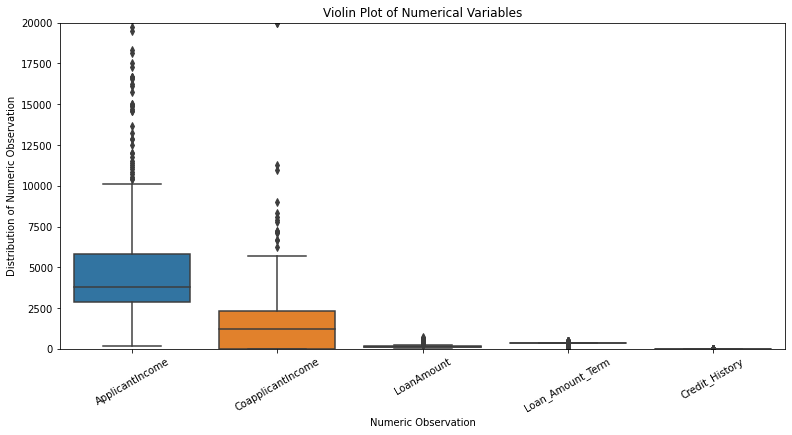

In [9]:
fig, ax = plt.subplots(figsize=(13,6))
gfg = sns.boxplot(data=df, ax=ax)
gfg.set(ylim=(0, 20000), 
        title='Violin Plot of Numerical Variables', 
        xlabel="Numeric Observation",
        ylabel="Distribution of Numeric Observation")
gfg.set_xticklabels(gfg.get_xticklabels(), rotation=30)

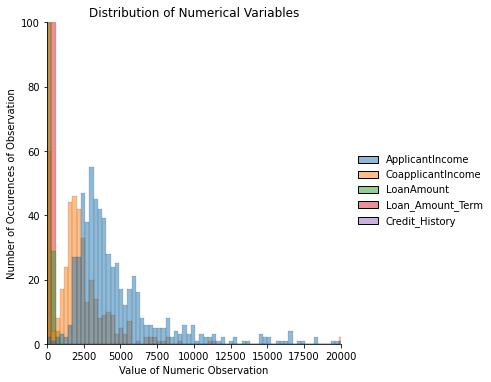

In [10]:
#This shows us that the numerical variables are right-skewed and not normally distributed
dfd = sns.displot(df)
dfd.set(ylim=(0, 100), 
        xlim = (0,20000)).set(title='Distribution of Numerical Variables', 
        xlabel = "Value of Numeric Observation", 
        ylabel = "Number of Occurences of Observation")

From the table above, we can see that a couple of columns (e.g. `Self_Employed` and `Loan_Term_Amount`) have more than 5% of null values, which is more than what we are comfortable with epsecially given the volume of our data. We can impute the missing values by taking the median if it's a numerical variable. Median imputation is preferred when the distribution is skewed, as the median is less sensitive to outliers than the mean. The exploratory analysis above shows that the distribution of the numeric variables are skewed.  We can impute the missing values by taking the mode if it's a numerical categorical variable. Mode imputation is suitable for categorical variables or numerical variables with a small number of unique values.

#### `Step 3.4: Imputation of missing values`

Some features we can make educated imputations for, such as `Gender`, `Dependents`, `Self_Employed` and `Credit_History`. 

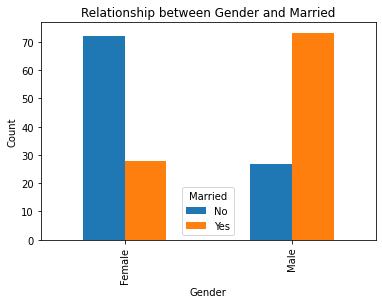

In [11]:
## Look at gender and married relationship

# df witth count of each combination of gender and married
percentages = df.groupby(['Gender', 'Married']).size().unstack() / len(df) * 100

# calculate the percentage for each category separately
gender_percentages = percentages.apply(lambda row: row / row.sum() * 100, axis=1)

# create a grouped bar chart with the percentage values
gender_percentages.plot(kind='bar', stacked=False)

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Relationship between Gender and Married')

plt.show()

From this we can see that Males are more likely to be married than not, while females are more likely to not be married than married. 

In [12]:
# Select the rows where gender is missing and they are married
df.loc[(df['Gender'].isna()) & (df['Married'] == 'Yes'), 'Gender'] = 'Male'

# Select all the other rows gender is na and make it 0 
df.loc[df['Gender'].isna(), 'Gender'] = 'Female'

For other features, we will apply more simplistic imputation based on the distributions of the feature. 

In [13]:
def impute_the_nulls(data):
    '''Impute the null values based on the type of data
    # param data: an array of featurized examples
    # return summary of null counts
    '''
    #data = data.drop(columns = ['Credit_History'])
    # calculate the number of nulls
    nulls = pd.DataFrame(data.isnull().sum(), columns=['nulls'])
    
    # create two lists for either numerical or categorical features
    cat_col_list = data.select_dtypes("object").columns.to_list()
    num_col_list = data.select_dtypes("number").columns.to_list()
    
    # null lists for categorical data
    cat_null_col_list = []
    for col in cat_col_list:
        if nulls.loc[col, 'nulls'] != 0:
            cat_null_col_list.append(col)
    
    # filling missing values with the mode for categorical features  
    for col in cat_null_col_list:
        data[col] = data[col].fillna(
        data[col].dropna().mode().values[0])
    
    # null lists for numerical data
    num_null_col_list = []
    for col in num_col_list:
        if nulls.loc[col, 'nulls'] != 0:
            num_null_col_list.append(col)
            
    # filling the missing values with the mean for numerical features
    for col in num_null_col_list:
        if col == 'Credit_History':
            break
        else:
            data[col] = data[col].fillna(
            data[col].dropna().median())
    
    return data.isnull().sum()

In [14]:
print("Number of nulls in training dataset after the nulls are imputed:")
impute_the_nulls(df)

Number of nulls in training dataset after the nulls are imputed:


Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term      0
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

#### `Step 3.5: Converting the categorial data to numerical data`

In [15]:
# create a list of columns whose values are either categorial or numerical
cat_col_list = df.select_dtypes("object").columns.to_list()
num_col_list = df.select_dtypes("number").columns.to_list()
# print(cat_col_list)
# print(num_col_list)

# split the data into categorial vs. numerical data
df_cat = df[cat_col_list]
df_num = df[num_col_list]
# print(df_cat)
# print(df_num)

# converting categorical values to numbers using LabelEncoder
oe = OrdinalEncoder()
encoded_data = oe.fit_transform(df_cat[['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']])
df_cat[['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']] = encoded_data
# print(df_cat)

# concatenate two data columns into one dataset
df = pd.concat([df_cat, df_num],axis=1)
print(df)

     Gender  Married  Dependents  Education  Self_Employed  Property_Area  \
0       1.0      0.0         0.0        0.0            0.0            2.0   
1       1.0      1.0         1.0        0.0            0.0            0.0   
2       1.0      1.0         0.0        0.0            1.0            2.0   
3       1.0      1.0         0.0        1.0            0.0            2.0   
4       1.0      0.0         0.0        0.0            0.0            2.0   
..      ...      ...         ...        ...            ...            ...   
609     0.0      0.0         0.0        0.0            0.0            0.0   
610     1.0      1.0         3.0        0.0            0.0            0.0   
611     1.0      1.0         1.0        0.0            0.0            2.0   
612     1.0      1.0         2.0        0.0            0.0            2.0   
613     0.0      0.0         0.0        0.0            1.0            1.0   

     Loan_Status  ApplicantIncome  CoapplicantIncome  LoanAmount  \
0      

#### `Step 3.6: CART Imputation for Credit_History`

Credit history is one of the most relevant features for understanding if a loan will be approved or not. Because of this, we want to make sure we try to impute this as accurately as we can, to help our predictive models below. We will attempt to use CART to help us impute the missing values.

In [16]:
Cart_data = df

In [17]:
## We are going to only focus on where credit history is blank
complete_data = Cart_data.dropna(subset=['Credit_History'])

# Split data so we can check CART performance before imputing
train_data, test_data = train_test_split(complete_data, test_size=0.1, random_state = 16)

# We cannot use loan status or credit history in our CART algorithm
features = complete_data.drop(['Loan_Status', 'Credit_History'], axis=1).columns

# Split data 
X_train = train_data[features]
X_test = test_data[features]
y_train = train_data['Credit_History']
y_test = test_data['Credit_History']

# Fit tree, based on some testing, will use max depth of 3 and min samples as 10, to prevent overfitting
model = DecisionTreeClassifier(max_depth = 3, min_samples_split=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# check performance 

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))


Accuracy: 0.9122807017543859
Precision: 0.9285714285714286
Recall: 0.9811320754716981
F1 score: 0.9541284403669724


In [18]:
# Impute Values
missing_data = df[df['Credit_History'].isnull()]
X_missing = missing_data[features]
y_preds = model.predict(X_missing)

df.loc[df['Credit_History'].isnull(), 'Credit_History'] = y_preds

In [19]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,5849,0.0,128.0,360.0,1.0
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4583,1508.0,128.0,360.0,1.0
2,1.0,1.0,0.0,0.0,1.0,2.0,1.0,3000,0.0,66.0,360.0,1.0
3,1.0,1.0,0.0,1.0,0.0,2.0,1.0,2583,2358.0,120.0,360.0,1.0
4,1.0,0.0,0.0,0.0,0.0,2.0,1.0,6000,0.0,141.0,360.0,1.0


In [20]:
df.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
Property_Area        0
Loan_Status          0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
dtype: int64

### Step 4: Exploratory Data Analysis

The Exploratory Data Analysis phase includes an exercise of looking at the distribution of overall loan status (labeled data) and distribution of features to identify patterns and trends, which can help us gain insights into the data and inform decisions about which performance metrics are appropriate for the data.

#### `Step 4.1: Histogram for loan status`

1.0    422
0.0    192
Name: Loan_Status, dtype: int64


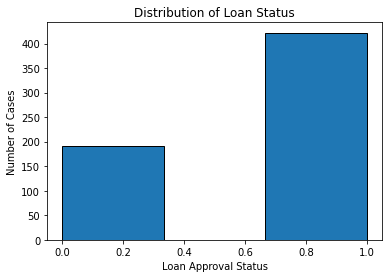

In [21]:
print(df['Loan_Status'].value_counts())

plt.figure(figsize=(6,4))
plt.hist(df['Loan_Status'], edgecolor='black', bins=3)
plt.xlabel("Loan Approval Status")
plt.ylabel("Number of Cases")
plt.title("Distribution of Loan Status")
plt.show()

#### `Step 4.2: Distribution of all our features`

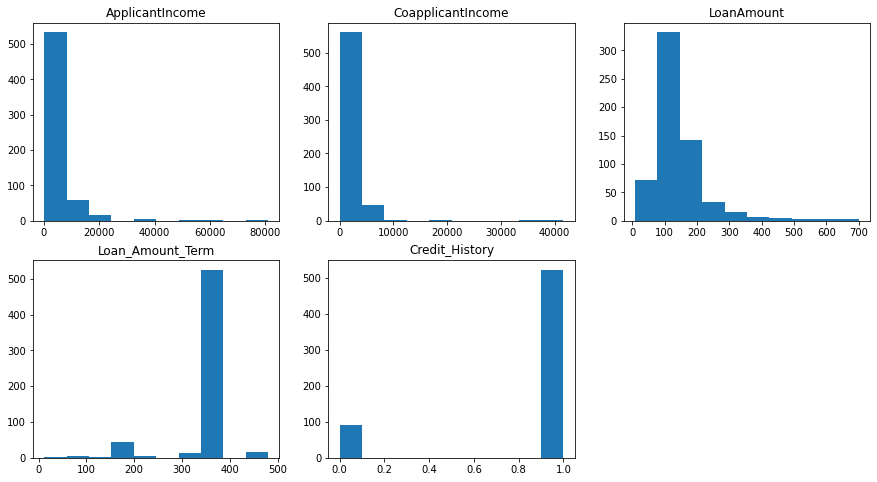

In [22]:
# Distribution of numerical features
plt.figure(figsize=(15, 8))

for idx, feature in enumerate(num_col_list):
    plt.subplot(2, 3, idx+1)
    df[feature].hist(bins=10, grid=False)
    plt.title(feature)

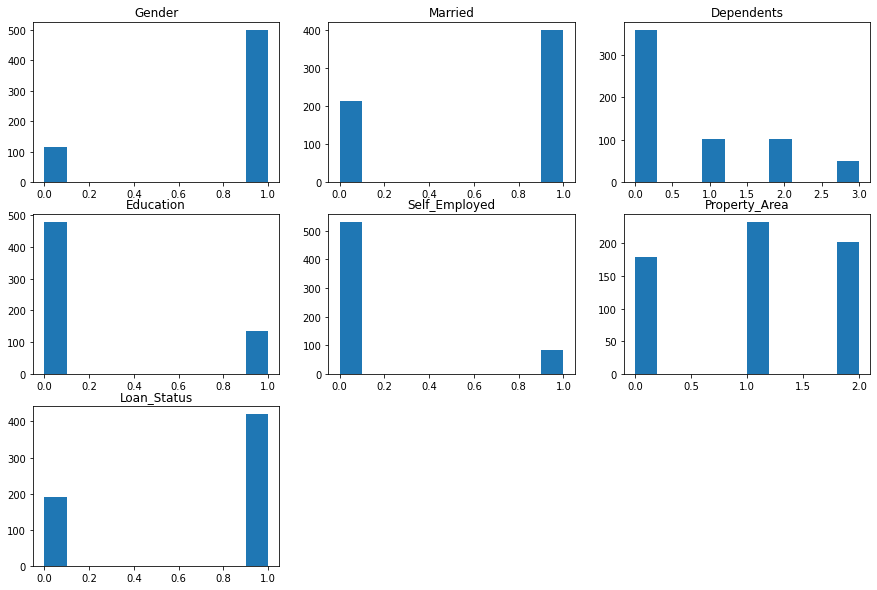

In [23]:
# Distribution of categorical features
plt.figure(figsize=(15, 10))

for idx, feature in enumerate(cat_col_list):
    plt.subplot(3, 3, idx+1)
    df[feature].hist(bins=10, grid=False)
    plt.title(feature)

#### `Step 4.3: Correlation matrix`

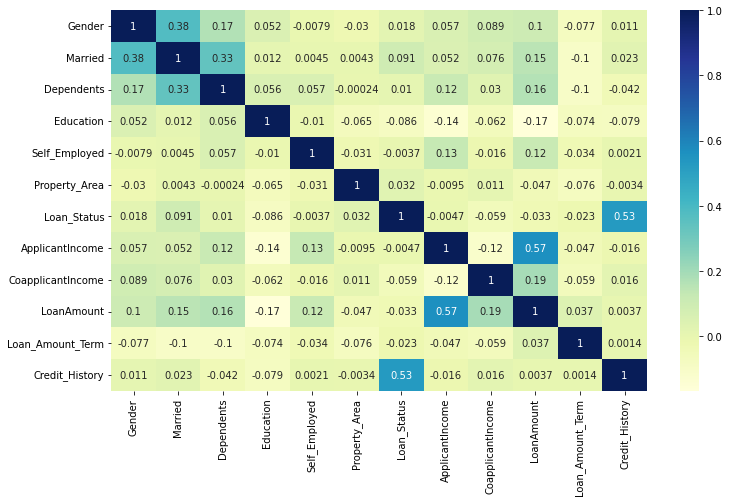

In [24]:
plt.figure(figsize=(12,7))
ax = sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')

We can see that `Credit_History` has the highest correlation with `Loan_Status` (a positive correlation of `0.54`).

### Step 5. Build, compile and evaluate the models 

#### `Step 5.1: Split the data into train, validation and test datasets`

In [25]:
# split the data into train, validation, and test datasets
X = df.drop('Loan_Status', axis=1)
Y = df['Loan_Status']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# print the sizes of the datasets
print('Train size:', X_train.shape, y_train.shape)
print('Validation size:', X_val.shape, y_val.shape)
print('Test size:', X_test.shape, y_test.shape)

# almost same ratio
print('\nRatio of target in y_train :', y_train.value_counts().values/ len(y_train))
print('Ratio of target in y_test :', y_test.value_counts().values/ len(y_test))
print('Ratio of target in original_data :', df['Loan_Status'].value_counts().values/ len(df))

Train size: (368, 11) (368,)
Validation size: (123, 11) (123,)
Test size: (123, 11) (123,)

Ratio of target in y_train : [0.70380435 0.29619565]
Ratio of target in y_test : [0.6504065 0.3495935]
Ratio of target in original_data : [0.68729642 0.31270358]


#### `Step 5.2: Define the baseline model`

Considering the distribution of the label data, `Loan_Status`, in our training data, we decided that our baseline model should always predict approval of the loan application. 

In [26]:
def baseline_model(x):
    Loan_Status_Counts = x.value_counts()

    Loan_Status_df = pd.DataFrame({'Loan_Status': Loan_Status_Counts.index, 
                                    'Count': Loan_Status_Counts.values, 
                                    'Percentage': Loan_Status_Counts.values/sum(Loan_Status_Counts.values)*100})
    return Loan_Status_df

In [27]:
y_train_baseline = baseline_model(y_train)
y_val_baseline = baseline_model(y_val)
y_test_baseline = baseline_model(y_test)

print('Baseline train accuracy: %.3f' % y_train_baseline.loc[0,'Percentage'])
print('Baseline validation accuracy: %.3f' % y_val_baseline.loc[0,'Percentage'])
print('Baseline test accuracy: %.3f' % y_test_baseline.loc[0,'Percentage'])

Baseline train accuracy: 70.380
Baseline validation accuracy: 67.480
Baseline test accuracy: 65.041


Based on above analysis, the baseline model predicts 70% accuracy using our training dataset, 67% for validation dataset and 65% for test dataset.  

#### `Step 5.3: Improve the baseline model - Logistic Regression`

In [28]:
# standardize the data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_val_std = sc.transform(X_val)
X_test_std = sc.transform(X_test)

In [29]:
models = {'LogisticRegression': LogisticRegression(random_state=42)}

In [30]:
# define the loss function
def loss(y_true, y_pred, retu=False):
    pre = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    loss = log_loss(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    
    if retu:
        return pre, rec, f1, loss, acc
    else:
        print('Precision score: %.3f\nRecall score: %.3f\nF1 score: %.3f\nLoss: %.3f\nAccuracy: %.3f' % (pre, rec, f1, loss, acc))

In [31]:
def train_eval_train(models, X, y):
    for name, model in models.items():
        print(name,':')
        model.fit(X, y)
        loss(y, model.predict(X))

In [32]:
# train_eval_train - non standardized     
print("Performance using non-standardized train dataset:\n")      
train_eval_train(models, X_train, y_train)

Performance using non-standardized train dataset:

LogisticRegression :
Precision score: 0.819
Recall score: 0.977
F1 score: 0.891
Loss: 6.073
Accuracy: 0.832


In [33]:
# train_eval_train - standardized
print("Performance using standardized train dataset:\n")          
train_eval_train(models, X_train_std, y_train)

Performance using standardized train dataset:

LogisticRegression :
Precision score: 0.816
Recall score: 0.977
F1 score: 0.889
Loss: 6.171
Accuracy: 0.829


In [34]:
# train_eval_train - standardized validation
print("Performance using standardized validation dataset:\n")  
train_eval_train(models, X_val_std, y_val)

Performance using standardized validation dataset:

LogisticRegression :
Precision score: 0.760
Recall score: 0.952
F1 score: 0.845
Loss: 8.498
Accuracy: 0.764


As discussed in the data pre-processing section using the correlation matrix, we observed that `Credit_History` has the best correlation score with our labeled data `Loan_Status` at approximately 57%. This makes us question if there are ways to perform a feature reduction and therefore improve the performance.

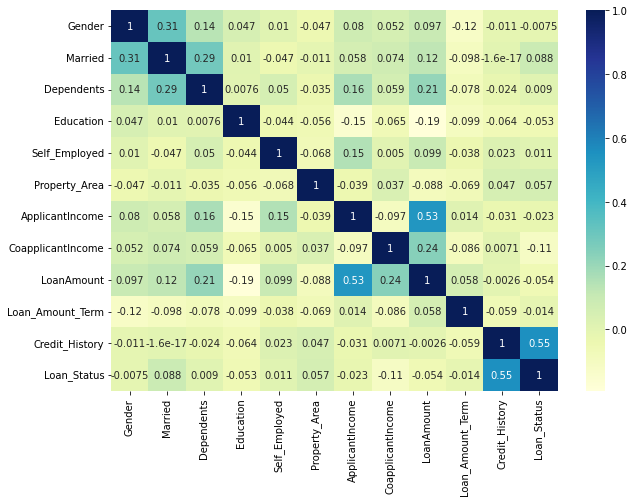

In [35]:
data_corr = pd.concat([X_train, y_train], axis=1)
corr = data_corr.corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, cmap='YlGnBu');

We also attempt dimensionality reduction by combining features to see if this could improve the correlation score.

In [36]:
# Trying different valiables to see how they perfom, since correlation isn't great before
X_train['CoapplicantIncome_div_ApplicantIncome'] = X_train['CoapplicantIncome'] / X_train['ApplicantIncome']  
X_train['LoanAmount_div_Loan_Amount_Term'] = X_train['LoanAmount'] * X_train['Loan_Amount_Term'] 

X_val['CoapplicantIncome_div_ApplicantIncome'] = X_val['CoapplicantIncome'] / X_val['ApplicantIncome']  
X_val['LoanAmount_div_Loan_Amount_Term'] = X_val['LoanAmount'] * X_val['Loan_Amount_Term'] 

X_test['CoapplicantIncome_div_ApplicantIncome'] = X_test['CoapplicantIncome'] / X_test['ApplicantIncome']  
X_test['LoanAmount_div_Loan_Amount_Term'] = X_test['LoanAmount'] * X_test['Loan_Amount_Term'] 

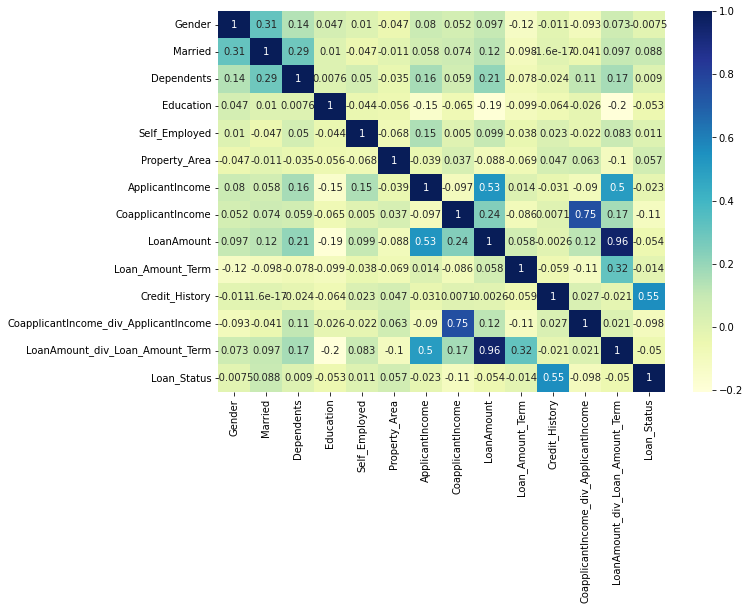

In [37]:
data_corr = pd.concat([X_train, y_train], axis=1)
corr = data_corr.corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, cmap='YlGnBu');

In [38]:
X_train.head()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,CoapplicantIncome_div_ApplicantIncome,LoanAmount_div_Loan_Amount_Term
254,1.0,0.0,0.0,0.0,1.0,2.0,16250,0.0,192.0,360.0,0.0,0.000000,69120.0
314,1.0,1.0,0.0,0.0,0.0,0.0,2473,1843.0,159.0,360.0,1.0,0.745249,57240.0
168,1.0,0.0,0.0,0.0,0.0,1.0,2237,0.0,63.0,480.0,0.0,0.000000,30240.0
305,1.0,0.0,0.0,1.0,0.0,2.0,2000,0.0,128.0,360.0,1.0,0.000000,46080.0
380,1.0,1.0,0.0,0.0,0.0,1.0,3333,2500.0,128.0,360.0,1.0,0.750075,46080.0


In [39]:
# Create a new df and drop columns
X_train = X_train.drop(columns = ['CoapplicantIncome', 'ApplicantIncome', 'Loan_Amount_Term', 'LoanAmount'])
X_val = X_val.drop(columns = ['CoapplicantIncome', 'ApplicantIncome', 'Loan_Amount_Term', 'LoanAmount'])
X_test = X_test.drop(columns = ['CoapplicantIncome', 'ApplicantIncome', 'Loan_Amount_Term', 'LoanAmount'])

In [40]:
X_train.head()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Credit_History,CoapplicantIncome_div_ApplicantIncome,LoanAmount_div_Loan_Amount_Term
254,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.000000,69120.0
314,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.745249,57240.0
168,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,30240.0
305,1.0,0.0,0.0,1.0,0.0,2.0,1.0,0.000000,46080.0
380,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.750075,46080.0


In [41]:
#re-standardize
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_val_std = sc.transform(X_val)

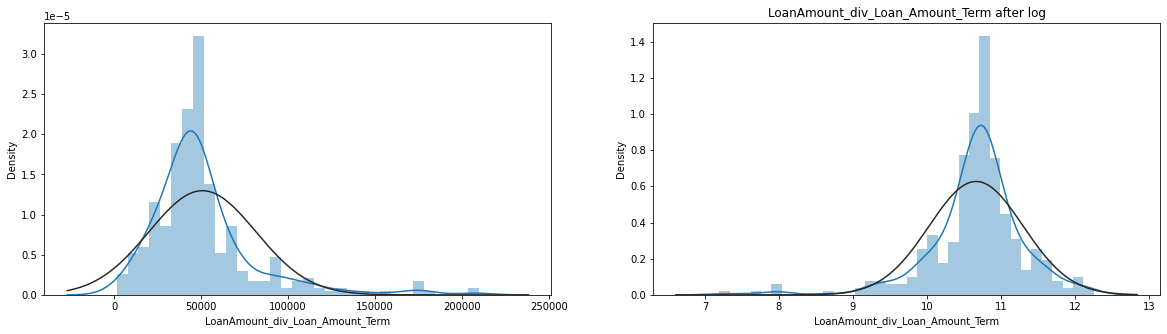

In [42]:
# look if these need stabndardized
fig, ax = plt.subplots(1,2,figsize=(20,5))
#sns.distplot(X_train['CoapplicantIncome_div_ApplicantIncome'], ax=ax[0], fit=norm) #not bad
sns.distplot(X_train['LoanAmount_div_Loan_Amount_Term'], ax=ax[0], fit=norm) # slightly skwewed

#apply log function to the skewed
X_train['LoanAmount_div_Loan_Amount_Term'] = np.log(X_train['LoanAmount_div_Loan_Amount_Term'])  # logarithm of all the values

sns.distplot(X_train['LoanAmount_div_Loan_Amount_Term'], ax=ax[1], fit=norm)
ax[1].set_title('LoanAmount_div_Loan_Amount_Term after log');

In [43]:
def train_eval_train(models, X, y):
    for name, model in models.items():
        print(name,':')
        model.fit(X, y)
        loss(y, model.predict(X))

In [44]:
# train_eval_train - non standardized     
print("Performance after feature reduction, using non-standardized train dataset:\n")      
train_eval_train(models, X_train, y_train)

Performance after feature reduction, using non-standardized train dataset:

LogisticRegression :
Precision score: 0.816
Recall score: 0.977
F1 score: 0.889
Loss: 6.171
Accuracy: 0.829


In [45]:
# train_eval_train - standardized
print("Performance using standardized train dataset:\n")          
train_eval_train(models, X_train_std, y_train)

Performance using standardized train dataset:

LogisticRegression :
Precision score: 0.816
Recall score: 0.977
F1 score: 0.889
Loss: 6.171
Accuracy: 0.829


In [46]:
# val_eval_train - standardized
print("Performance using standardized validation dataset:\n")  
train_eval_train(models, X_val_std, y_val)

Performance using standardized validation dataset:

LogisticRegression :
Precision score: 0.755
Recall score: 0.964
F1 score: 0.847
Loss: 8.498
Accuracy: 0.764


In [47]:
# test_eval_train - standardized
print("Performance using standardized test dataset:\n")  
train_eval_train(models, X_test_std, y_test)

Performance using standardized test dataset:

LogisticRegression :
Precision score: 0.767
Recall score: 0.988
F1 score: 0.863
Loss: 7.326
Accuracy: 0.797


#### `Step 5.4: Improve the baseline model - FFNN`

The third model is to build a neural network model with one dense layer and a sigmoid activation function, which makes it a binary classification model.

In [61]:
def build_nn_model(num_features):
    """Return a simple logistic regression neural network model using the Keras Sequential API."""
  
    # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    
    # Use Keras Sequential API to build a logistic regression
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Dense(
        units=1,  # dimensionality of output vector
        activation='sigmoid', # logistic regression
        input_shape=(num_features,)
    ))
  
    # Use Binary Crossentropy as our loss and the Adam optimizer.
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy']
    )
    return model

In [62]:
def plot_history(history): 
    # grab history
    history = history.history

    # plot loss for train and validation
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 2, 1)
    plt.plot(history['loss'], lw=2, color='darkgoldenrod')
    plt.plot(history['val_loss'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    ax.set_xlabel('Epochs', size=10)
    ax.set_title('Loss');

    # plot accuracy for train and validation
    ax = fig.add_subplot(1, 2, 2)
    plt.plot(history['accuracy'], lw=2, color='darkgoldenrod')
    plt.plot(history['val_accuracy'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    ax.set_xlabel('Epochs', size=10)
    ax.set_title('Accuracy');
    
    plt.show()

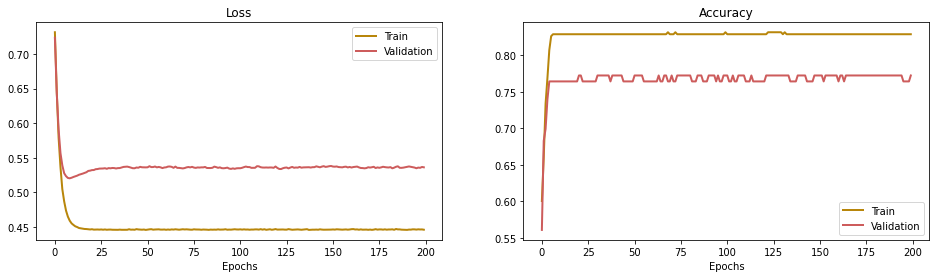

In [72]:
# train the model for 200 epochs on the train and validation data
model = build_nn_model(num_features=9)
history = model.fit(x=X_train_std,
                y=y_train,
                validation_data=(X_val_std, y_val),
                epochs=200,
                verbose=0
)
history_df = pd.DataFrame(history.history)
plot_history(history)

In [73]:
print('FFNN train accuracy: %.3f' % history_df['accuracy'].max())
print('FFNN val accuracy: %.3f' % history_df['val_accuracy'].max())

FFNN train accuracy: 0.832
FFNN val accuracy: 0.772


In [64]:
# run the model for 200 epochs on the test dataset
model = build_nn_model(num_features=9)
history = model.fit(x=X_test_std,
                y=y_test,
                epochs=200,
                verbose=0
)
history_df = pd.DataFrame(history.history)

In [65]:
print('FFNN test accuracy: %.3f' % history_df['accuracy'].max())

Baseline test accuracy: 0.805


#### `Step 5.5: Improve the baseline model - FFNN with hyperparameter tuning`

Using phase 3 model (FFNN), we decided to work with three hyperparameters to improve the performance: learning_rates, optimizers, and the dropout_rates.

In [66]:
def build_improved_nn_model(num_features,
                            learning_rate,
                            optimizer):
    """Return a simple logistic regression model using the Keras Sequential API."""
  
    # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    
    # Use Keras Sequential API to build a logistic regression
    model = tf.keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
    
    model.add(tf.keras.layers.Dense(
        units=1,  # dimensionality of output vector
        use_bias=True,
        activation='sigmoid', # "linear" for linear regression or blank as default
        #kernel_initializer='random_normal',
        #bias_initializer='zeros',
        #kernel_initializer=initializers.RandomNormal(stddev=0.01),
        #bias_initializer=initializers.RandomNormal(stddev=0.01),
        name="Output"
    ))
    
    # Use Binary Crossentropy as our loss and specified optimizer.
    if optimizer=="Adam":
        model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        )
    else:
        model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        )
    
    return model

In [67]:
# Initializing the learning_rate and optimizer
learning_rate = [0.001, 0.01, 0.1]
optimizer = ['Adam', 'SGD']
epoch = [100, 200, 300]
table = []

for lr in learning_rate:
    for op in optimizer:       
        
        # Randomizing the learning_rate and optimizer and run the training model   
        model = build_improved_nn_model(num_features=9,
                                       learning_rate=lr,
                                       optimizer=op)
        
        for ep in epoch:
            # Evaluate the result on the train data first
            history = model.fit(
                  x = X_train_std,  
                  y = y_train, 
                  validation_data=(X_val_std, y_val), 
                  epochs=ep,             
                  verbose=0             
                  )

            history_df = pd.DataFrame(history.history)
            train_accuracy = list(history_df['binary_accuracy'])[-1]
            validation_accuracy = list(history_df['val_binary_accuracy'])[-1]
            table.append([lr, op, ep, train_accuracy, validation_accuracy])

cols = ['Learning Rate', 'Optimizer', 'Epoch', 'Training Accuracy', 'Validation Accuracy']
pd.DataFrame(table, columns = cols)

,Learning Rate,Optimizer,Epoch,Training Accuracy,Validation Accuracy
0,0.001,Adam,100,0.828804,0.772358
1,0.001,Adam,200,0.828804,0.772358
2,0.001,Adam,300,0.828804,0.772358
3,0.001,SGD,100,0.728261,0.739837
4,0.001,SGD,200,0.790761,0.764228
5,0.001,SGD,300,0.831522,0.756098
6,0.010,Adam,100,0.828804,0.772358
7,0.010,Adam,200,0.828804,0.772358
8,0.010,Adam,300,0.828804,0.772358
9,0.010,SGD,100,0.828804,0.772358


In [68]:
model = build_improved_nn_model(num_features=9,
                               learning_rate=0.1,
                                optimizer='Adam')
history = model.fit(x=X_test_std,
                y=y_test,
                epochs=200,
                verbose=0
)
history_df = pd.DataFrame(history.history)

In [70]:
print('Improved FFNN test accuracy: %.3f' % history_df['binary_accuracy'].max())

Improved FFNN test accuracy: 0.813
